In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from create_dataframe import create_warming_df
from kmeans_functions import create_graph, elbow_method, silhouette_method

import seaborn as sns

### Is it possible to train a Neural Network to classify the country based on the parameters?

# K Model Built using data downloaded from Kaggle with additional data scrapped from Wikipedia

Shape of df: (224, 22)

Things to be careful of when building this model is there are a lot of null values replaced with '0'. This allows us to have a deeper dataset. It may be worth looking into pruning the data more. Certain columns that it might be worth dropping (values of 0):
- population: 37
- pop_density_km: 37
- land_area: 36
- total_area: 35

I found that dropping areas where the Population was 0 gave us the best results, leaving over only a few countries that still had most of the data points that we require

My conclusion after running this is if I want to get usable results, we have to use PCA to reduce the dimensions of our data.

TODO: Look at the other clustering algorithm (4, 6) clusters and see what countries got clustered with canada, china, russia, and the US

In [4]:
df = create_warming_df()
df = df[df['population']!=0]
df.head(1)

,name,ISO3,region,region_id,latitude,longitude,avg_indicator,coastline_km,coast_area_ratio,total_area,...,percent_water,eco_footprint,biocapacity,carbon_intensity_2018,population,pop_density_km,avg_elevation_km,max_elevation_km,min_elevation_km,annual_precipitation_avg_mm
0,afghanistan,AFG,Asia,0,33.0,65.0,0.459623,0.0,0.0,652864,...,0.1,0.79,0.5,0.16,34262840,65.0,1.884,7.492,0.258,327.0


In [5]:
# Create the database we will work, removing all non-numeric columns
df2 = df[df.columns[6:-1]]
df2.shape

(187, 15)

In [7]:
# Pick a random seed for randomness, so we can replicate results
seed = 0
np.random.seed(seed)

# Scale our data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df2), columns = df2.columns)

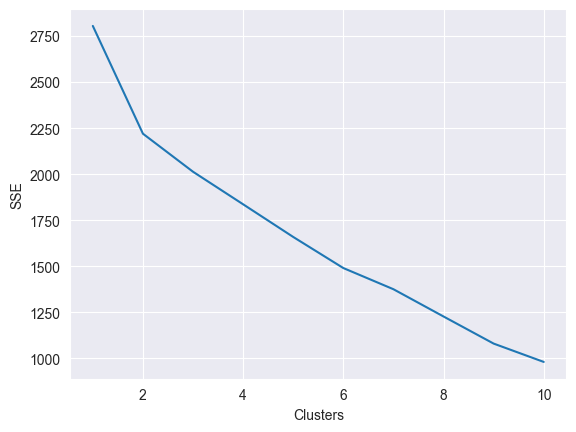

In [8]:
elbow_method(scaled_df)

In [10]:
# Create a k means model
n_cluster = silhouette_method(scaled_df)

kmeans = KMeans(init="k-means++", n_clusters=n_cluster, n_init=10)
kmeans.fit(scaled_df)

For n_clusters = 2 , the average silhouette_score is : 0.6384670132661437


KMeans(n_clusters=2, n_init=10)

In [11]:
df_results = create_warming_df()

df_results.insert(0, "kmeans_cluster", kmeans.labels_)
df_results[df_results['kmeans_cluster'] == 1]

,kmeans_cluster,name,ISO3,region,region_id,latitude,longitude,avg_indicator,coastline_km,coast_area_ratio,...,percent_water,eco_footprint,biocapacity,carbon_intensity_2018,population,pop_density_km,avg_elevation_km,max_elevation_km,min_elevation_km,annual_precipitation_avg_mm
8,1,australia,AUS,Oceania,3,-27.0,133.0,0.482098,66530.0,8.66,...,0.8,9.31,16.57,0.34,26821557,3.0,0.330,2.2280,-0.0150,534.0
22,1,brazil,BRA,Americas,4,-10.0,-55.0,0.537443,33379.0,3.99,...,0.6,3.11,9.08,0.16,203080756,25.0,0.320,2.9950,0.0000,1761.0
29,1,canada,CAN,Americas,4,60.0,-95.0,0.639951,265523.0,29.20,...,8.9,8.17,16.01,0.35,40769890,4.0,0.487,5.9590,0.0000,537.0
34,1,china,CHN,Asia,0,35.0,105.0,0.564459,30017.0,3.22,...,2.8,3.38,0.94,0.57,1409670000,149.0,1.840,0.0000,0.0000,645.0
72,1,india,IND,Asia,0,20.0,77.0,0.290639,17181.0,5.78,...,9.6,1.16,0.45,0.29,1392329000,435.0,0.160,8.5860,-0.0020,1083.0
137,1,russia,RUS,Europe,1,60.0,100.0,0.730115,110310.0,6.74,...,4.2,5.69,6.79,0.47,146203613,8.0,0.600,5.6420,-0.0280,460.0
178,1,united states,USA,Americas,4,38.0,-97.0,0.477918,133312.0,14.60,...,7.1,8.4,3.76,0.30,335893238,35.0,0.760,6.1905,-0.0855,715.0


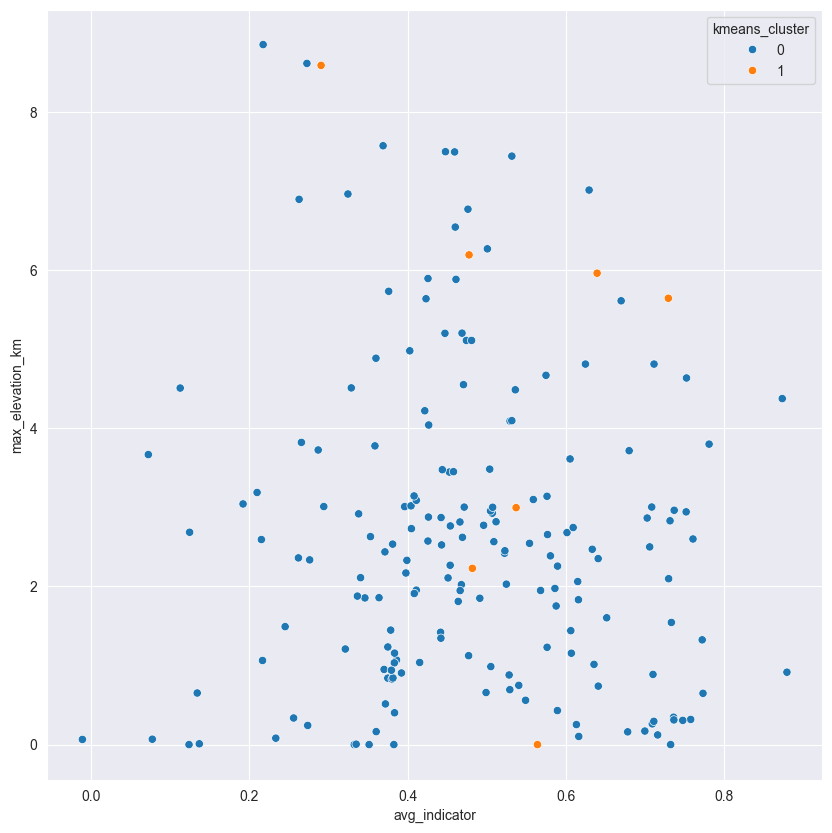

In [12]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_results, x=df_results['avg_indicator'], y=df_results['max_elevation_km'], hue=df_results['kmeans_cluster'])
plt.show()

kmeans_no_d_

Looking at the results it seems that our model clusters based on similar size? CHN, USA, and RUS are expected but CAN is the outlier
- Max Elevation: China has a null value, find and replace this value

Judging from the results of these I am going to 1) attempt to add more clusters and 2) use PCA for dimensionality reduction

In [43]:
# Attempt to add more clusters:
scaler = StandardScaler()
scaled_df_2 = pd.DataFrame(scaler.fit_transform(df2), columns = df2.columns)
kmeans_2 = KMeans(init="k-means++", n_clusters=4, n_init='auto')
kmeans_2.fit(scaled_df_2)

df_results = create_warming_df()

df_results.insert(0, "kmeans_cluster", kmeans_2.labels_)

for i in range(4):
    print(df_results[df_results['kmeans_cluster'] == i].shape)

(51, 23)
(4, 23)
(13, 23)
(119, 23)


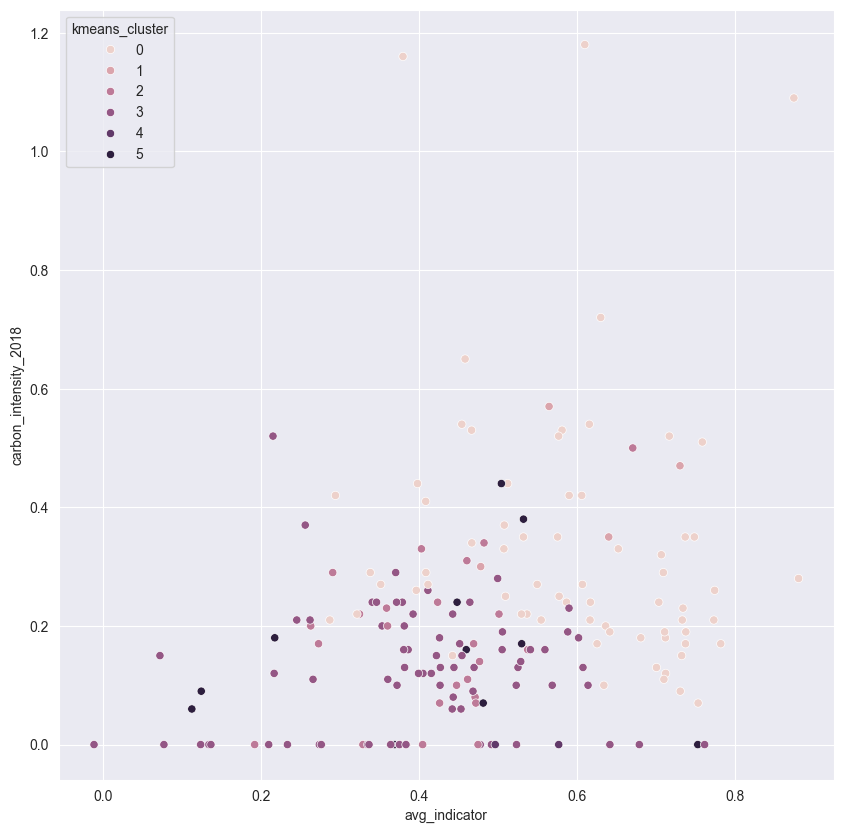

In [49]:
plt.figure(figsize=(10, 10))
sns.color_palette("hls", 8)
sns.scatterplot(data=df_results, x=df_results['avg_indicator'], y=df_results['carbon_intensity_2018'], hue=df_results['kmeans_cluster'])
plt.show()

In [46]:
# Attempt to add more clusters:
scaler = StandardScaler()
scaled_df_3 = pd.DataFrame(scaler.fit_transform(df2), columns = df2.columns)
kmeans_3 = KMeans(init="k-means++", n_clusters=6, n_init='auto')
kmeans_3.fit(scaled_df_3)

df_results_3 = create_warming_df()

df_results_3.insert(0, "kmeans_cluster", kmeans_3.labels_)

for i in range(6):
    print(df_results_3[df_results_3['kmeans_cluster'] == i].shape)

(37, 23)
(31, 23)
(101, 23)
(3, 23)
(13, 23)
(2, 23)


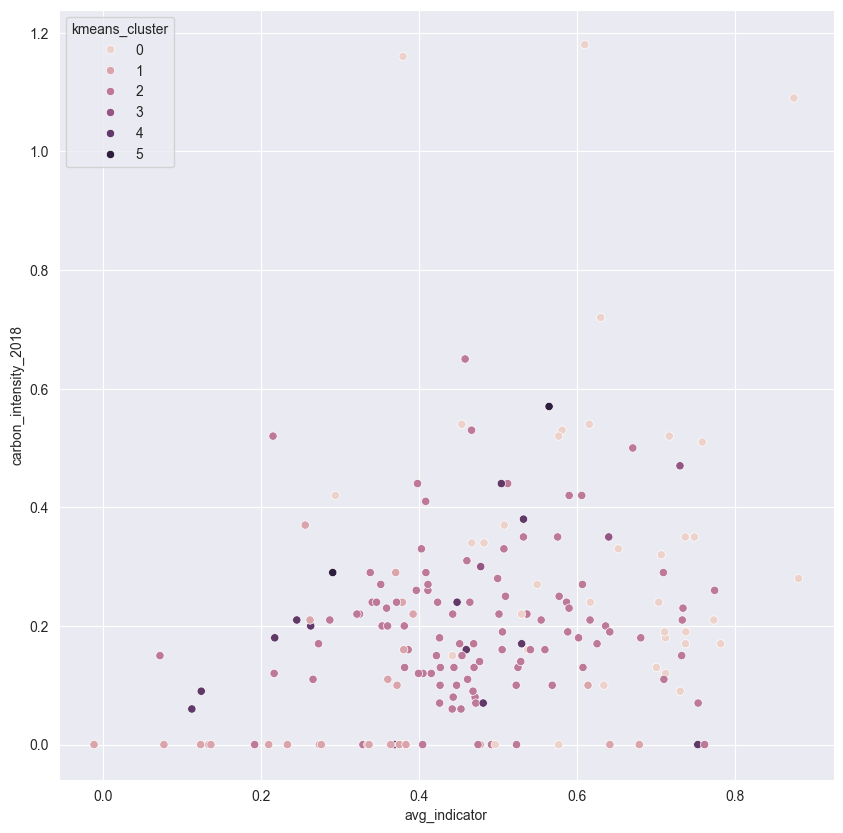

In [48]:
plt.figure(figsize=(10, 10))
sns.color_palette("hls", 8)
sns.scatterplot(data=df_results_3, x=df_results_3['avg_indicator'], y=df_results_3['carbon_intensity_2018'], hue=df_results_3['kmeans_cluster'])
plt.show()